In [51]:
import pandas as pd
import numpy as np
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage
import cv2

In [2]:
# PATHs

## The directory where the dune data is stored
ORI_DATA_PATH = '../ori_data'

## The directory where the three databases are stored
DATABASE_PATH = '../database'

## The directory where the visualization data for each visualization is stored
VIS_DATA_PATH = '../../data'

## The directory where the scraped tweets data is stored
TWEET_PATH = '../ori_data/tweets'

In [8]:
# read transaction database
tx_db = pd.read_csv('{}/tx_db.csv'.format(DATABASE_PATH), index_col=0)

# read cryptopunk database
punk_db = pd.read_csv('{}/punk_db.csv'.format(DATABASE_PATH), index_col=0)
punk_db['attributes'] = punk_db['attributes'].apply(eval)

# read trader database
trader_db = pd.read_csv('{}/trader_db.csv'.format(DATABASE_PATH), index_col=0)

# read tweet database
tweets_db = pd.read_csv('{}/tweets_db.csv'.format(DATABASE_PATH), lineterminator='\n')


In [69]:
df_sa = pd.read_csv('{}/vis5_df_sa.csv'.format(VIS_DATA_PATH), lineterminator='\n')
df_sa = df_sa[df_sa['date'] > '2017-01-01']
df_sa

id                 date  \
0       880138889511436289  2017-06-28 19:00:38   
1       881049753169010688  2017-07-01 07:20:04   
2       882240852017467393  2017-07-04 14:13:05   
3       882776637422448640  2017-07-06 01:42:06   
4       884644278294544384  2017-07-11 05:23:26   
...                    ...                  ...   
83240  1523280063529365504  2022-05-08 12:34:02   
83241  1523282476382052353  2022-05-08 12:43:38   
83242  1523283530456834049  2022-05-08 12:47:49   
83243  1523283971261743106  2022-05-08 12:49:34   
83244  1523285376634216449  2022-05-08 12:55:09   

                                                 content  \
0      trust me. i’m a designer. @jamesvictore https:...   
1      once you're through those gym doors the only t...   
2      nft ohio &amp; nexgen athlete @xandero66 conti...   
3        i don't trust people who age without wrinkles 😂   
4      dear me,  i guess its hard to trust anyone but...   
...                                                  ...   
83240  @mediavenir @elonjet metamask wallet trust nft...   
83241  the first responsible for the mess the #nft sp...   
83242  @dunkindonuts i lost my metamask trust wallet ...   
83243  requesting $sol funds from the #stakely faucet...   
83244  [rugtator quickcall] [trust into it 9.5/10]  g...   

                                                     url         username  \
0      https://twitter.com/purity_nft/status/88013888...       purity_nft   
1      https://twitter.com/Gavin_John_NFT/status/8810...   Gavin_John_NFT   
2      https://twitter.com/Coach_UQB/status/882240852...        Coach_UQB   
3      https://twitter.com/Gavin_John_NFT/status/8827...   Gavin_John_NFT   
4      https://twitter.com/thebuttlord_NFT/status/884...  thebuttlord_NFT   
...                                                  ...              ...   
83240  https://twitter.com/spacecrevette/status/15232...    spacecrevette   
83241  https://twitter.com/izildurrr/status/152328247...        izildurrr   
83242  https://twitter.com/mel_the_super/status/15232...    mel_the_super   
83243  https://twitter.com/ZAHA_NFT/status/1523283971...         ZAHA_NFT   
83244  https://twitter.com/Chopinger/status/152328537...        Chopinger   

                                                    text sentiment  polarity  
0                        trust m designer dangerousideas       neu  0.000000  
1             re gym doors thing separates us work ethic       neu  0.000000  
2      nft ohio amp nexgen athlete continues impress ...       pos  0.400000  
3                don t trust people age without wrinkles       neu  0.000000  
4      dear guess hard trust anyone never give met wr...       neg -0.395833  
...                                                  ...       ...       ...  
83240  metamask wallet trust nft crypto lionel messi ...       neu  0.000000  
83241  first responsible mess nft space buyers consta...       pos  0.118056  
83242  lost metamask trust wallet sugar daddy nft eth...       neu  0.000000  
83243  requesting sol funds stakely faucet solana blo...       neu  0.000000  
83244  rugtator quickcall trust 9 5 10 gm chop team t...       pos  0.377778  

[83245 rows x 8 columns]

### Data for the Bar Chart

In [162]:
data_path = '../../data/vis5_data.csv'

sent_year_df = pd.read_csv(data_path, header=0, index_col=0)
sent_year_df

neg       neu       pos  neg_count  neu_count  pos_count
2017  0.116279  0.651163  0.232558          5         28         10
2018  0.094059  0.554455  0.351485         19        112         71
2019  0.180328  0.327869  0.491803         55        100        150
2020  0.153677  0.250274  0.596048        140        228        543
2021  0.131661  0.235315  0.633025       4151       7419      19958
2022  0.148778  0.312003  0.539219       7477      15680      27099

In [163]:
sent_year_df.loc[2017]

neg           0.116279
neu           0.651163
pos           0.232558
neg_count     5.000000
neu_count    28.000000
pos_count    10.000000
Name: 2017, dtype: float64

In [155]:
def sen_distribution_per_year(df_sa, year):
    df_sa_year = df_sa[df_sa['date'].apply(lambda x: x.split('-')[0] == year)]
    sent_ = (df_sa_year.groupby('sentiment').count()).loc[:, 'content']
    sent_ = pd.DataFrame(sent_)
    sent_.reset_index(inplace=True)
    tweets_count = np.sum(sent_['content'])
    sent_['percentage'] = sent_['content'] /tweets_count
    # sent_.to_csv('{}/vis5/sent_distribution_{}.csv'.format(VIS_DATA_PATH, year))
    # print('> Saved: {}/vis5/sent_distribution_{}.csv'.format(VIS_DATA_PATH, year))
    return sent_


def get_vis5_data(df_sa):
    sent_year_dict = dict()
    # Get sentiment distribution per year
    for year in ['2017', '2018', '2019', '2020', '2021', '2022']:
        sent_df = sen_distribution_per_year(df_sa, year)
        sent_per = sent_df.percentage.tolist()
        sent_count = sent_df.content.tolist()
        sent_year_dict[year] = sent_per + sent_count
    
    # Convert to dataframe
    sent_year_df = pd.DataFrame.from_dict(sent_year_dict, orient='index')
    sent_year_df.columns = ['neg', 'neu', 'pos', 'neg_count', 'neu_count', 'pos_count']
    
    return sent_year_df
    
# Save
sent_year_df = get_vis5_data(df_sa)
sent_year_df.to_csv('{}/vis5_data.csv'.format(VIS_DATA_PATH))
sent_year_df


neg       neu       pos  neg_count  neu_count  pos_count
2017  0.116279  0.651163  0.232558          5         28         10
2018  0.094059  0.554455  0.351485         19        112         71
2019  0.180328  0.327869  0.491803         55        100        150
2020  0.153677  0.250274  0.596048        140        228        543
2021  0.131661  0.235315  0.633025       4151       7419      19958
2022  0.148778  0.312003  0.539219       7477      15680      27099

In [165]:
import plotly.graph_objects as go
years=['2017', '2018', '2019', '2020', '2021', '2022']

fig = go.Figure(data=[
    go.Bar(name='Negative', x=years, y=sent_year_df['neg'], marker=dict(color='#E00000')),
    go.Bar(name='Neutral', x=years, y=sent_year_df['neu'], marker=dict(color='#FFBA08')),
    go.Bar(name='Positive', x=years, y=sent_year_df['pos'], marker=dict(color='#3F88C5')),
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

### Data for the WordCloud

In [166]:
color_dict = {'neg': '#E00000', 'neu': '#FFBA08', 'pos': '#3F88C5'}

In [181]:
def hex_to_rgb(hex_code):
    h = hex_code.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    
def rgb_to_hsl(r, g, b):
    r = float(r)
    g = float(g)
    b = float(b)
    high = max(r, g, b)
    low = min(r, g, b)
    h, s, v = ((high + low) / 2,)*3

    if high == low:
        h = 0.0
        s = 0.0
    else:
        d = high - low
        s = d / (2 - high - low) if low > 0.5 else d / (high + low)
        h = {
            r: (g - b) / d + (6 if g < b else 0),
            g: (b - r) / d + 2,
            b: (r - g) / d + 4,
        }[high]
        h /= 6

    return h, s, v

def hex_to_hsl(hex_code):
    return rgb_to_hsl(*hex_to_rgb(hex_code))

In [187]:
hex_to_hsl('#E00000')

(0.0, 1.0, 112.0)

> Saved: ../../data/vis5/2017_neg.png
> Saved: ../../data/vis5/2017_neu.png
> Saved: ../../data/vis5/2017_pos.png
> Saved: ../../data/vis5/2018_neg.png
> Saved: ../../data/vis5/2018_neu.png
> Saved: ../../data/vis5/2018_pos.png
> Saved: ../../data/vis5/2019_neg.png
> Saved: ../../data/vis5/2019_neu.png
> Saved: ../../data/vis5/2019_pos.png
> Saved: ../../data/vis5/2020_neg.png
> Saved: ../../data/vis5/2020_neu.png
> Saved: ../../data/vis5/2020_pos.png
> Saved: ../../data/vis5/2021_neg.png
> Saved: ../../data/vis5/2021_neu.png
> Saved: ../../data/vis5/2021_pos.png
> Saved: ../../data/vis5/2022_neg.png
> Saved: ../../data/vis5/2022_neu.png
> Saved: ../../data/vis5/2022_pos.png


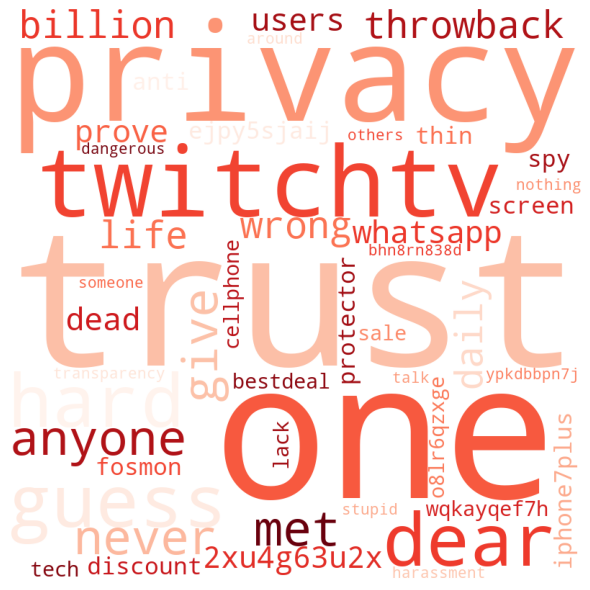

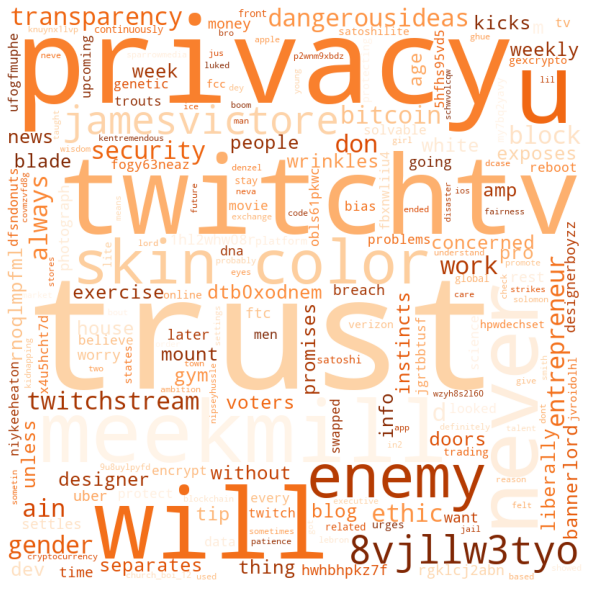

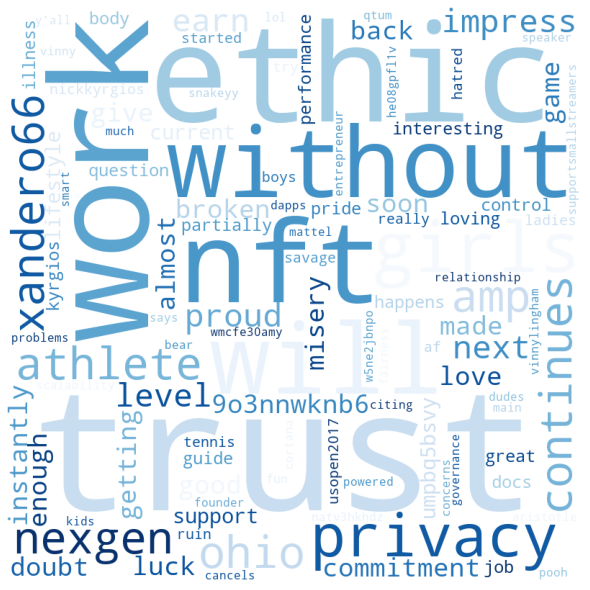

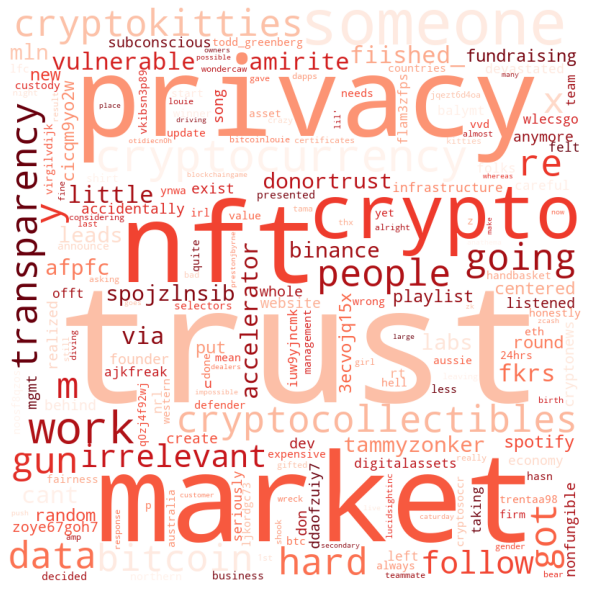

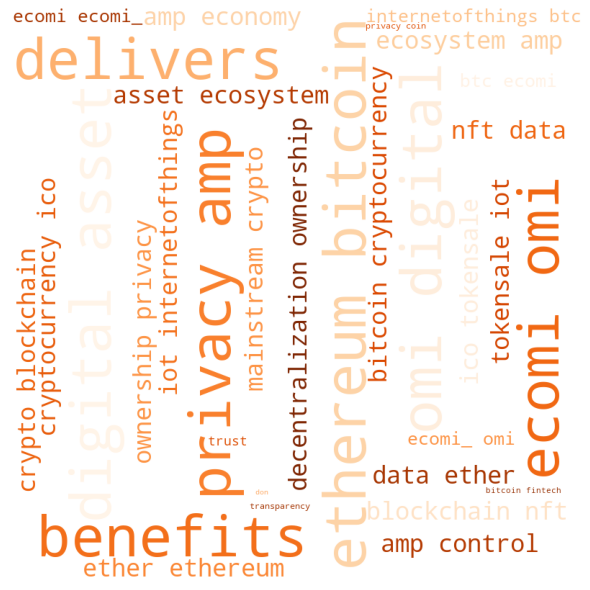

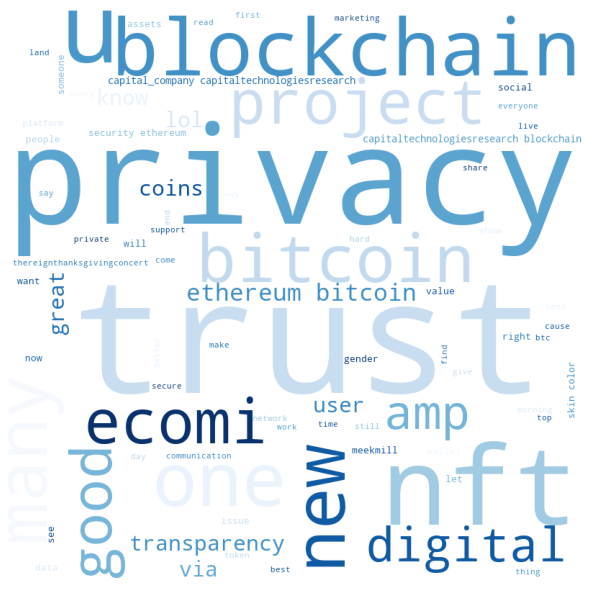

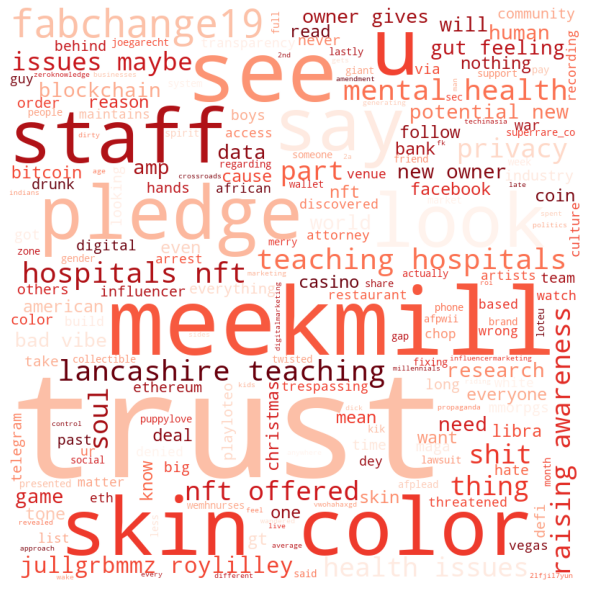

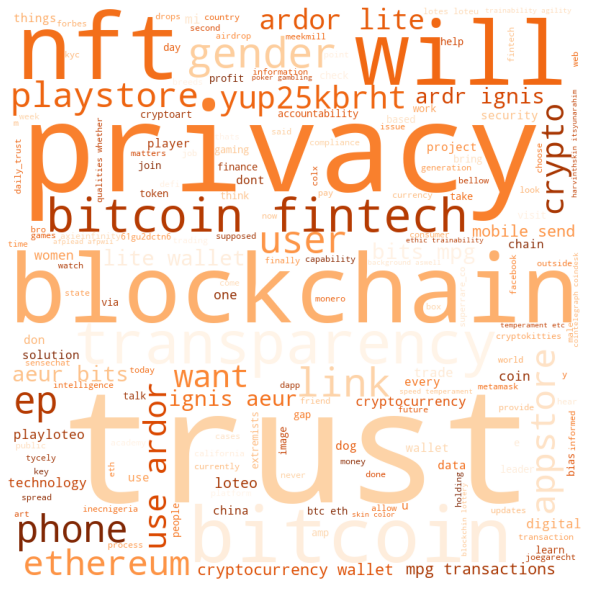

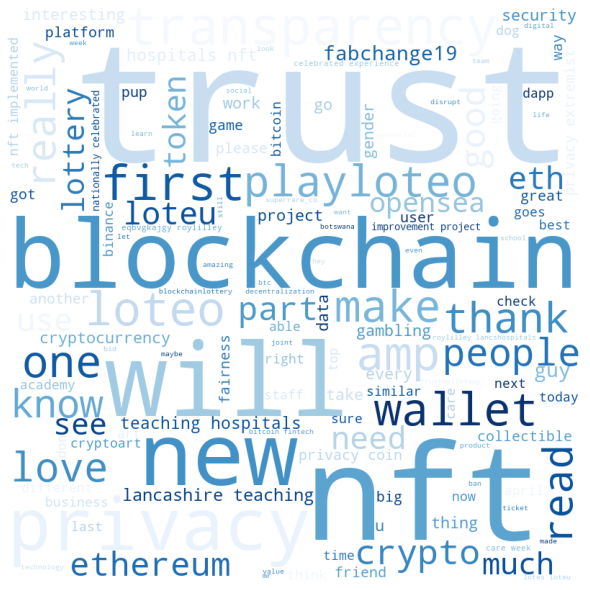

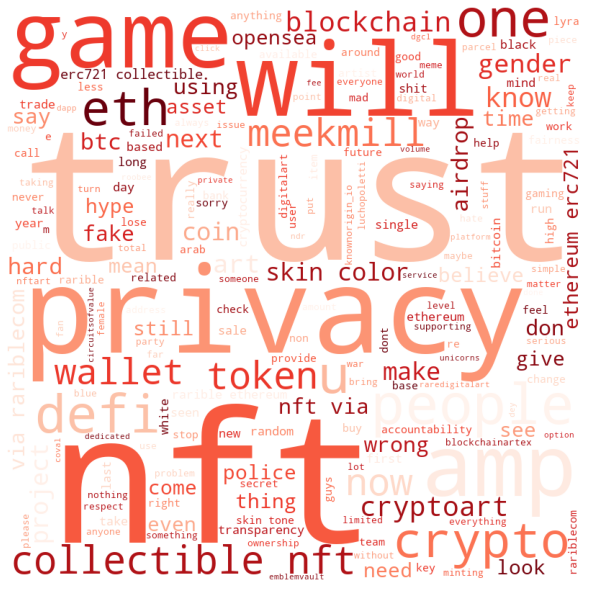

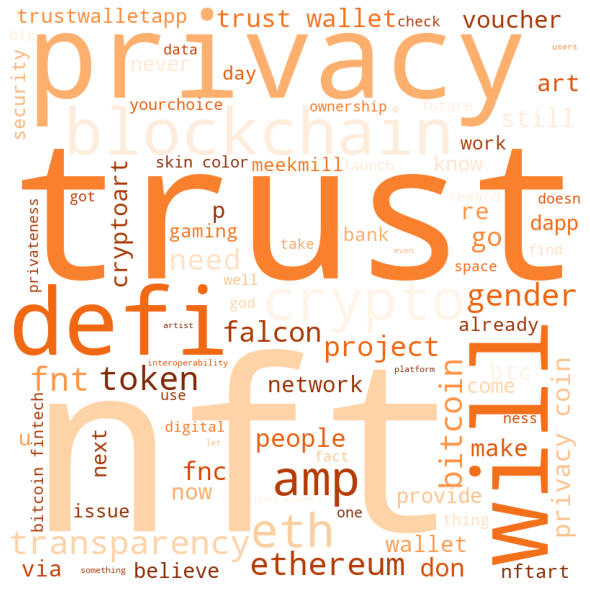

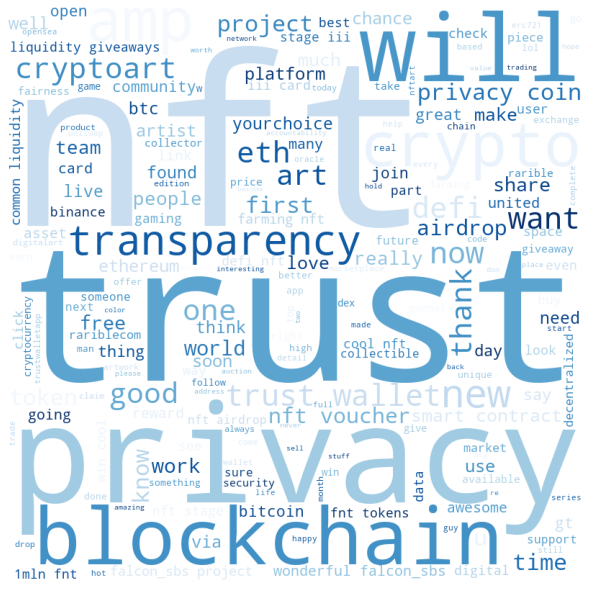

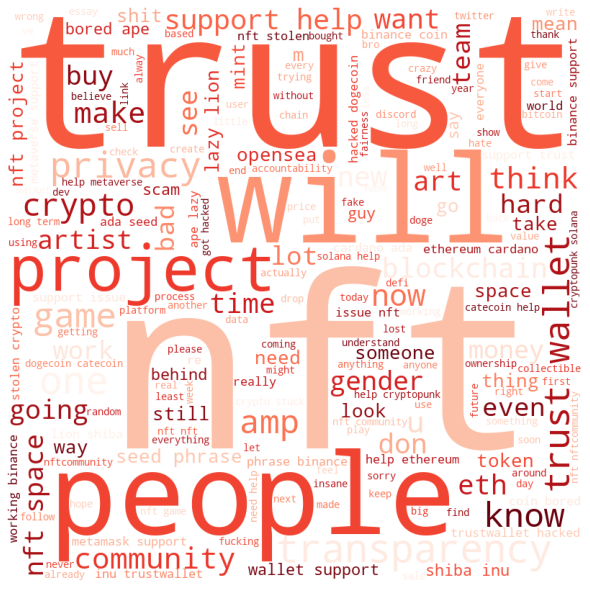

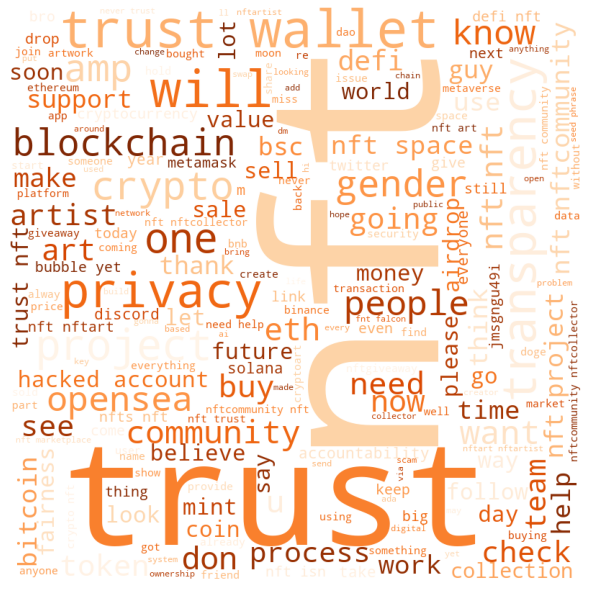

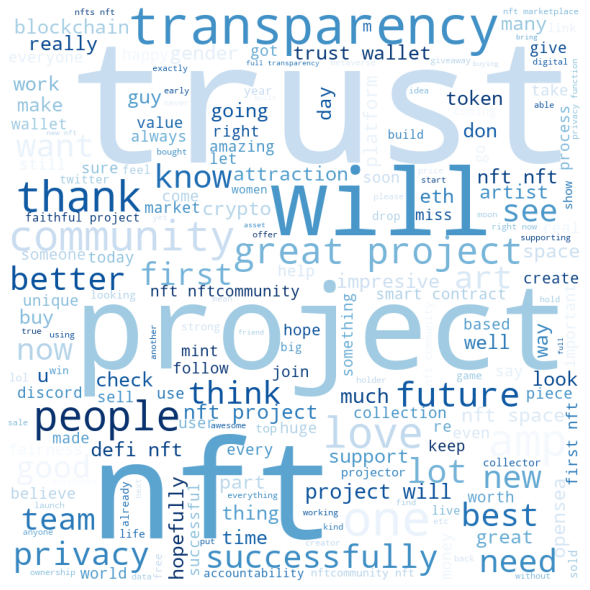

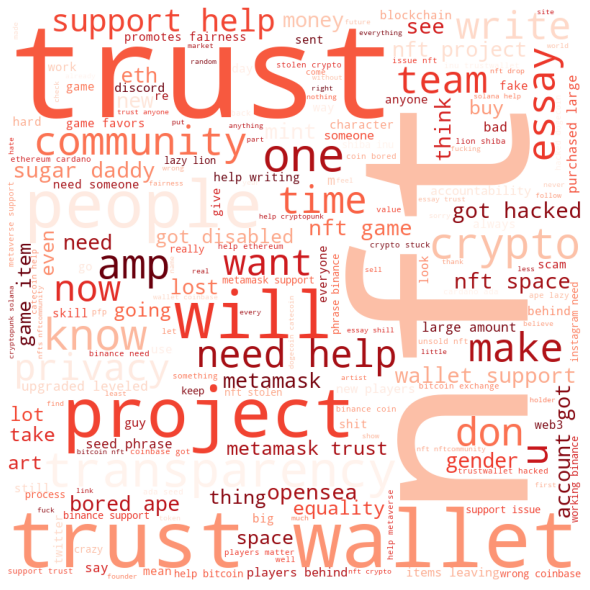

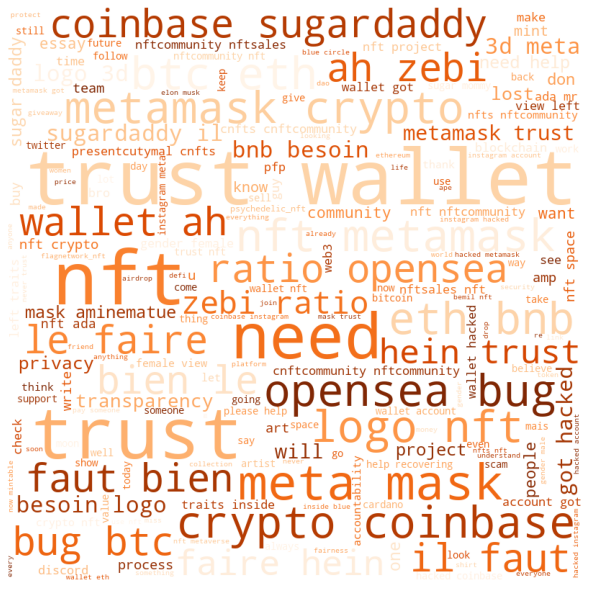

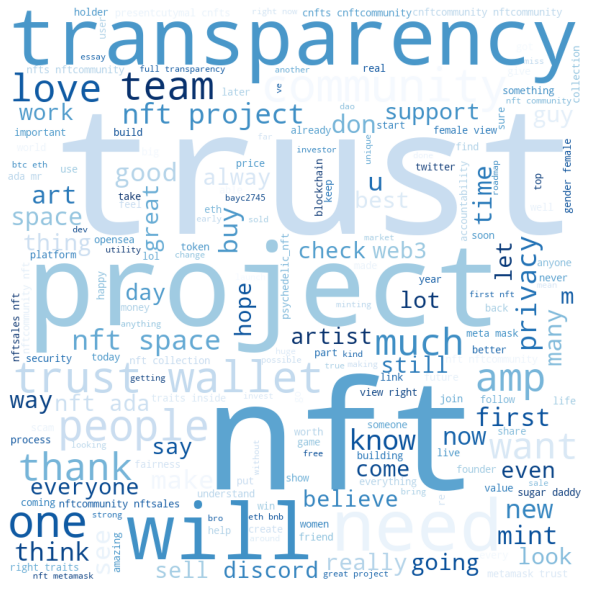

In [197]:
# [2017_neg, 2018_neg, 2019_neg, 2020_neg, 2021_neg, 2022_neg]
# [2017_neu, 2018_neu, 2019_neu, 2020_neu, 2021_neu, 2022_neu]
# [2017_pos, 2018_pos, 2019_pos, 2020_pos, 2021_pos, 2022_pos]
import random

# def grey_color_func(word, font_size, position, orientation, random_state=None,
#                     **kwargs):
#     return "hsl(12, 1%%, %d%%)" % random.randint(60, 100)

def save_word_cloud(df_sa, year, sent):
    # Get tweets content for a specific year and merge them into one string
    df = df_sa[df_sa['date'].apply(lambda x: x.split('-')[0] == year)]
    df = df[df['sentiment'] == sent]
    df['wc_text'] = df["content"].apply(lambda x:str(x))
    tweet_text_all = '\n'.join(df["wc_text"])
    
    # Set stopwords
    stopwords = set(STOPWORDS)
    stopwords.add("http")
    stopwords.add("https")
    stopwords.add("co")
    stopwords.add("s")
    stopwords.add("t")
    
    # Wordcloud Object
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(tweet_text_all)
    
    if sent == 'neg':
        wordcloud.recolor(colormap='Reds', random_state=3)
    elif sent == 'neu':
        wordcloud.recolor(colormap='Oranges', random_state=3)
    elif sent == 'pos':
        wordcloud.recolor(colormap='Blues', random_state=3)
    
    # show
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig('{}/vis5/{}_{}.png'.format(VIS_DATA_PATH, year, sent))
    print('> Saved: {}/vis5/{}_{}.png'.format(VIS_DATA_PATH, year, sent))
    
    return wordcloud


for year in ['2017', '2018', '2019', '2020', '2021', '2022']:
    for sent in ['neg', 'neu', 'pos']:
        save_word_cloud(df_sa, year, sent)

#### WordCloud Test

In [159]:
def get_word_cloud(df_sa, year):
    # Get tweets content for a specific year and merge them into one string
    df = df_sa[df_sa['date'].apply(lambda x: x.split('-')[0] == year)]
    df['wc_text'] = df["content"].apply(lambda x:str(x))
    tweet_text_all = '\n'.join(df["text"])
    
    # Set color masking
    image = cv2.imread('8348.png')
    print("Size of image before pyrUp: ", image.shape)
    image = cv2.pyrUp(image)
    image = cv2.pyrUp(image)
    image = cv2.pyrUp(image)
    print("Size of image after pyrUp: ", image.shape)
    
    punk_coloring = np.array(image)
    
    # Set stopwords
    stopwords = set(STOPWORDS)
    stopwords.add("http")
    stopwords.add("s")
    
    # Wordcloud Object
    wc = WordCloud(width = 800, height = 800, 
                   background_color="white", max_words=2000, mask=punk_coloring,
                    stopwords=stopwords, max_font_size=40, random_state=42)
    
    wc.generate(tweet_text_all)
    
    # Create coloring from image
    image_colors = ImageColorGenerator(punk_coloring)
    
    # show
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wc.recolor(color_func=image_colors))
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    # fig, axes = plt.subplots(1, 3)
    # axes[0].imshow(wc, interpolation="bilinear")
    # # recolor wordcloud and show
    # # we could also give color_func=image_colors directly in the constructor
    # axes[1].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    # axes[2].imshow(punk_coloring, cmap=plt.cm.gray, interpolation="bilinear")
    # for ax in axes:
    #     ax.set_axis_off()
    plt.show()
    
    return wc